# Similar Charity Recommender - Built Using CharityNavigator Dataset

## Imports

In [1]:
import numpy as np
import pandas as pd
import datetime
import math
import random
import sys
from textwrap import wrap

pd.options.display.max_columns = 50

In [2]:
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set(color_codes=True)
# import folium
# import plotly.graph_objects as go


In [4]:
import pprint
from collections import defaultdict
import gensim
from gensim import corpora, models, similarities
# NLTK Stop words
from nltk.corpus import stopwords


## Functions

In [5]:
def sort_db_value(db,value,asc=False):
    return db.sort_values(by = value, ascending = asc)

def freq_array(freq_list):
    freq = []
    for i in freq_list:
        freq.append(i)
    return freq
        
def wrap_axis_labels(labels_list,wrap_length=13):
    labels_list = [ '\n'.join(wrap(l, wrap_length)) for l in labels_list]
    return labels_list

In [6]:
def set_labels(freq, ax,horz_shift=.2,vert_shift=1000,w="bold",fsize=10,c="b"):
    '''
    Function
    --------
    Set Frequency Labels on Bar Plot
    
    Parameters
    ----------
    freq : List of frequencies to plot for each bar
    ax : Axis to Plot Frequency Labels on
    horz_shift : Shift labels left/right
    vert_shift : Shift labels up/down
    w : "weight" -> Bold by defauly
    fsize : fontsize
    c : label color
    '''
    for i, v in enumerate(freq):
        ax.text(i-horz_shift,v+vert_shift, str(round(v,2)), weight = w,fontsize=fsize,color = c)
    pass

In [49]:
def set_labels_horizontal(freq, ax,horz_shift=.2,vert_shift=1000,w="bold",fsize=10,c="b"):
    '''
    Function
    --------
    Set Frequency Labels on Bar Plot
    
    Parameters
    ----------
    freq : List of frequencies to plot for each bar
    ax : Axis to Plot Frequency Labels on
    horz_shift : Shift labels left/right
    vert_shift : Shift labels up/down
    w : "weight" -> Bold by defauly
    fsize : fontsize
    c : label color
    '''
    for i, v in enumerate(freq):
        ax.text(v-horz_shift,i+vert_shift, str(round(v,2)), weight = w,fontsize=fsize,color = c)
    pass

In [7]:
def process_corpus(text_corpus,min_words=3,max_percent=0.1):
    '''
    Function
    --------
    Process corpus by removing stopwords, lowercasing tokenized words,
        removing words ocurring in only 1 document or more than 10% of documents
    
    Parameters
    ----------
    text_corpus : Unprocessed Text Corpus
    
    Returns:
    -------
    processed_corpus : Processed Text Corpus
    ''' 
    # Remove Stop Words
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_',
                   'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 
                   'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 
                   'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
    
    # Lowercase each document, split it by white space and filter out stopwords
    texts = ""
    texts = [[word for word in document.lower().split() if word not in stop_words] for document in text_corpus]
    
    # Count word frequencies
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1
        
    # Only keep words that appear more than [min_words] times, 
    # are in less than [max_percent] of documents, and are alphabetical strings
    max_percent_calc = (int(len(text_corpus)*(max_percent)))
    
    processed_corpus = []
    for text in texts:
        token_list = []
        for token in text:
            if frequency[token] > min_words and frequency[token] < max_percent_calc and str.isalpha(token):
                token_list.append(token)
        processed_corpus.append(token_list)
    
    return processed_corpus

In [8]:
def create_index_from_corpus(processed_corpus):
    '''
    Function
    --------
    Trains model on processed corpus
    
    Also creates dictionary of words from processed corpus
    
    Parameters
    ----------
    processed_corpus : Processed Text Corpus
    
    Returns:
    -------
    
    ''' 
    dictionary = corpora.Dictionary(processed_corpus)
    features = (len(dictionary))
    
    # Convert documents into Bag of Words (BoW) format
    bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
    
    # train the model
    tfidf = models.TfidfModel(bow_corpus)
    
    # Get cosine similarity of vectors of documents
    index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=features)
    
    return index, dictionary, tfidf

In [9]:
def find_similar_charities_category_score(train_df,test_df,column):
    '''
    Function
    --------
    Train Model on "corpus" column - composed of charity category, description, motto and state
    
    Parameters
    ----------
    train_df : DataFrame to Train LDA Model
    test_df : DataFrame to Test and Score Model
    
    Returns:
    -------
    top_3_sim : DataFrame of Top 3 Most Similar Charities
    '''
    total = 0
    category_counter = {1:0,2:0,3:0}
    document_min_words_cutoff = 200
    
    print("1. Processing Training Corpus")
    
    char_desc_trimmed = np.array(train_df[column])
    corpus = char_desc_trimmed
    
    processed_corpus = process_corpus(corpus)
    
    print("2. Creating Model from Training Corpus")
    index, dictionary, tfidf = create_index_from_corpus(processed_corpus)
    
    print("3. Starting Test Corpus Category Analysis\n")
    for ind, document in enumerate(test_df[column]):
        total +=1 
        if total % 500 == 0:
            print("Analyzed",total,"documents...")
         
        query_bow = dictionary.doc2bow(document.split())
        sims = index[tfidf[query_bow]]
        
        top_3_sim = dict()
        count = 3
        
        for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[1:4]:
            
            if count > 0:
                top_3_sim[document_number] = score
            count -= 1
            
        category_count = 1
        
        for doc, score in top_3_sim.items():
            if train_df['category'].iloc[doc] == test_df['category'].iloc[ind]:
                category_counter[category_count] += 1
            category_count += 1
        
    first_rec_score = round((category_counter[1] / total)*100,2)
    second_rec_score = round((category_counter[2] / total)*100,2)
    third_rec_score = round((category_counter[3] / total)*100,2)
    
    print ("\nFirst Recommendation Score:", first_rec_score,"%")
    print ("Second Recommendation Score:", second_rec_score,"%")   
    print ("Third Recommendation Score:", third_rec_score,"%\n")
    
    print ("AVG Recommendation Score:", round((first_rec_score+second_rec_score+third_rec_score)/3,2),"%")
    
    return top_3_sim
    

In [10]:
def find_similar_charities_similar_score(train_df,test_df,column):
    '''
    Function
    --------
    Train Model on "corpus" column - composed of charity category, description, motto and state
    
    Parameters
    ----------
    train_df : DataFrame to Train LDA Model
    test_df : DataFrame to Test and Score Model
    
    Returns:
    -------
    top_3_sim : DataFrame of Top 3 Most Similar Charities
    '''
    total = 0
    category_counter = {1:0,2:0,3:0}
    document_min_words_cutoff = 200
    
    print("1. Processing Training Corpus")
    
    char_desc_trimmed = np.array(train_df[column])
    
    corpus = char_desc_trimmed
    processed_corpus = process_corpus(corpus)
    
    print("2. Creating Model from Training Corpus")
    index, dictionary, tfidf = create_index_from_corpus(processed_corpus)
    
    print("3. Starting Test Corpus Similarity Analysis\n")
    for ind, document in enumerate(test_df[column]):
        total +=1 
        if total % 500 == 0:
            print("Analyzed",total,"documents...")
        
        
        query_bow = dictionary.doc2bow(document.split())
        sims = index[tfidf[query_bow]]
        
        top_3_sim = dict()
        count = 3
        
        for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[1:4]:
            
            if count > 0:
                top_3_sim[document_number] = score
            count -= 1
            
        category_count = 1
        
        for doc, score in top_3_sim.items():     
            category_counter[category_count] += score
            category_count +=1
    
    first_rec_score = round((category_counter[1] / total)*100,2)
    second_rec_score = round((category_counter[2] / total)*100,2)
    third_rec_score = round((category_counter[3] / total)*100,2)
    
    print ("\nFirst Recommendation Score:", first_rec_score,"%")
    print ("Second Recommendation Score:", second_rec_score,"%")   
    print ("Third Recommendation Score:", third_rec_score,"%\n")
    
    print ("AVG Recommendation Score:", round((first_rec_score+second_rec_score+third_rec_score)/3,2),"%")
    
    return top_3_sim
    

In [11]:
def find_similar_charities_from_search(train_df,search_text):
    '''
    Function
    --------
    Train Model on "corpus" column - composed of charity category, description, motto and state
    
    Parameters
    ----------
    train_df : DataFrame to Train LDA Model
    test_df : DataFrame to Test and Score Model
    
    Returns:
    -------
    top_3_sim : DataFrame of Top 3 Most Similar Charities
    '''
    total = 0
    category_counter = {1:0,2:0,3:0}
    document_min_words_cutoff = 200
    
    print("1. Processing Training Corpus")
    
    char_desc_trimmed = np.array(train_df['corpus'])
    
    corpus = char_desc_trimmed
    processed_corpus = process_corpus(corpus)
    
    print("2. Creating Model from Training Corpus")
    index, dictionary, tfidf = create_index_from_corpus(processed_corpus)
    
    print(dictionary.values())
    
    print("3. Starting Test Corpus Similarity Analysis\n")
    
    total +=1 
    if total % 500 == 0:
        print("Analyzed",total,"documents...")

    query_bow = dictionary.doc2bow(search_text.split())
    sims = index[tfidf[query_bow]]
    
    top_3_sim = dict()
    count = 3

    for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[1:4]:

        if count > 0:
            top_3_sim[document_number] = score
        count -= 1

    category_count = 1

    for doc, score in top_3_sim.items():     
        category_counter[category_count] += score
        category_count +=1
    
    first_rec_score = round((category_counter[1] / total)*100,2)
    second_rec_score = round((category_counter[2] / total)*100,2)
    third_rec_score = round((category_counter[3] / total)*100,2)
    
    print ("\nFirst Recommendation Score:", first_rec_score,"%")
    print ("Second Recommendation Score:", second_rec_score,"%")   
    print ("Third Recommendation Score:", third_rec_score,"%\n")
    
    print ("AVG Recommendation Score:", round((first_rec_score+second_rec_score+third_rec_score)/3,2),"%")
    
    return top_3_sim
    

In [12]:
def create_sim_word_dict(text1, text2, dictionary):
    '''
    '''
    text1_array = text1.split()
    text2_array = text2.split()

    dict_list = []
    for i in range(len(dictionary)):
        dict_list.append(dictionary[i])
    dict_list = np.array(dict_list)

    similar_words = dict()

    for word in text1_array:
        if word in text2_array and word in dict_list:
            if word not in similar_words:
                similar_words[word] = 1
            else:
                similar_words[word] +=1

    return similar_words

## Loading Charity Navigator Data

In [13]:
charity_navigator_df = pd.read_csv('../data/charities_rated_corpus.csv')
charity_navigator_df.drop(columns=['Unnamed: 0'],inplace=True)
charity_navigator_df.head()

,name,ein,category,description,motto,score,state,corpus
0,1000 Friends of Oregon,930642086,Environment,Working with Oregonians to enhance our quality...,Great communities. Working lands. Iconic Places.,91.94,OR,Environment Working with Oregonians to enhance...
1,WYPR,311770828,"Arts, Culture, Humanities",Serving the metropolitan Baltimore area and th...,88.1 FM -. Your NPR News Station,85.59,MD,"Arts, Culture, Humanities Serving the metropol..."
2,VSS Catholic Communications,911857425,Religion,VSS Catholic Communications is dedicated to an...,Spirit Catholic Radio Network,76.80,NE,Religion VSS Catholic Communications is dedica...
3,Utah Symphony & Opera,510145980,"Arts, Culture, Humanities",The mission of the Utah Symphony & Opera is to...,"Engaging, educating, and enriching lives",91.95,UT,"Arts, Culture, Humanities The mission of the U..."
4,Two Ten Footwear Foundation,222579809,Human Services,"Funded solely by the footwear industry, Two Te...",Shoepeople Helping Shoepeople,90.26,MA,Human Services Funded solely by the footwear i...


In [14]:
## Cleaning the Original Charity Navigator Data
# charity_navigator_df = pd.read_csv('../data/CLEAN_charity_data.csv')
# charity_navigator_df = charity_navigator_df[['name','ein','category','description','motto','score','state']]
# charity_navigator_df['ein'] = charity_navigator_df['ein'].apply(lambda x: int(x.replace("-","")))
# charity_navigator_df = charity_navigator_df.fillna("")
# charity_navigator_df['corpus'] = (charity_navigator_df['category'] + " " + charity_navigator_df['description'] + " " +charity_navigator_df['motto']+" "+ charity_navigator_df['state'])

# Exploratory Data Analysis

In [15]:
charity_navigator_df.head()

,name,ein,category,description,motto,score,state,corpus
0,1000 Friends of Oregon,930642086,Environment,Working with Oregonians to enhance our quality...,Great communities. Working lands. Iconic Places.,91.94,OR,Environment Working with Oregonians to enhance...
1,WYPR,311770828,"Arts, Culture, Humanities",Serving the metropolitan Baltimore area and th...,88.1 FM -. Your NPR News Station,85.59,MD,"Arts, Culture, Humanities Serving the metropol..."
2,VSS Catholic Communications,911857425,Religion,VSS Catholic Communications is dedicated to an...,Spirit Catholic Radio Network,76.80,NE,Religion VSS Catholic Communications is dedica...
3,Utah Symphony & Opera,510145980,"Arts, Culture, Humanities",The mission of the Utah Symphony & Opera is to...,"Engaging, educating, and enriching lives",91.95,UT,"Arts, Culture, Humanities The mission of the U..."
4,Two Ten Footwear Foundation,222579809,Human Services,"Funded solely by the footwear industry, Two Te...",Shoepeople Helping Shoepeople,90.26,MA,Human Services Funded solely by the footwear i...


## Category

In [61]:
charity_navigator_df.groupby('category').size().sort_values(ascending=False)[:10]

category
Human Services               2379
Arts, Culture, Humanities    1218
Health                        847
Community Development         803
Education                     667
International                 610
Animals                       454
Religion                      450
Environment                   429
Human and Civil Rights        346
dtype: int64

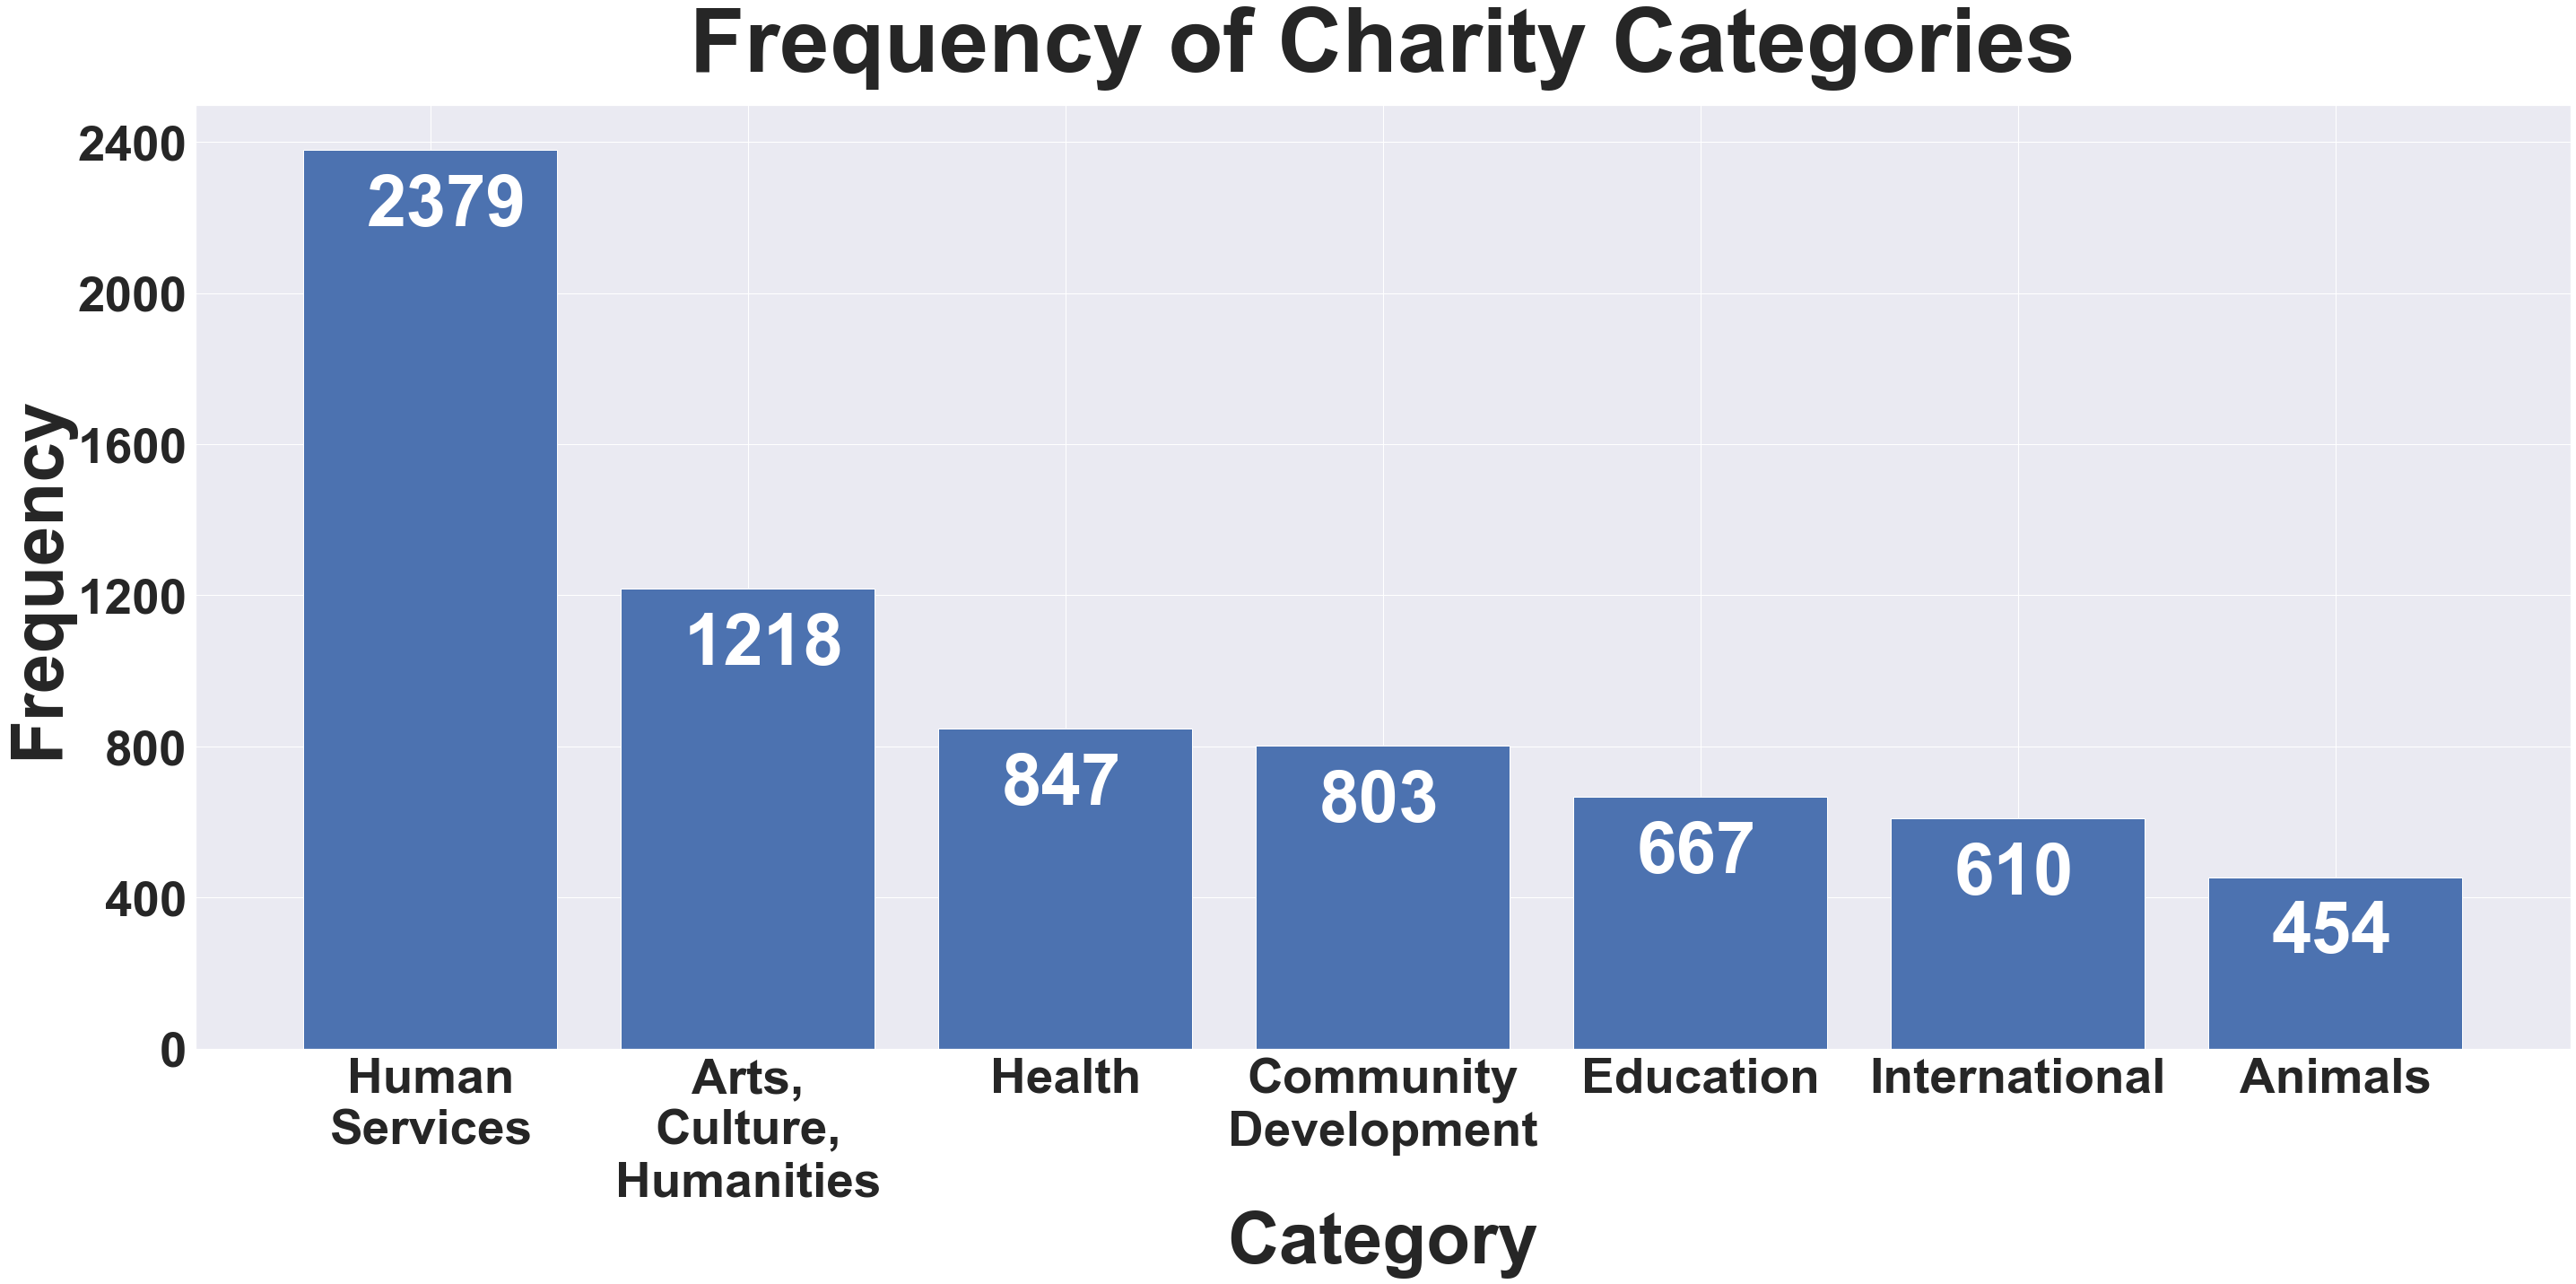

In [106]:
## Add Bar Chart

category_count = charity_navigator_df.groupby('category').size().sort_values(ascending=False)[:7]
categories = list(category_count.index.values)
freq = freq_array(category_count)

fig,ax = plt.subplots(figsize = (40,20))
ax.bar(categories,freq, color = "b");

# Title
ax.set_title("Frequency of Charity Categories", weight = "bold", fontsize = 100, y=1.03);

# X-axis
categories_wrapped = wrap_axis_labels(categories, wrap_length=13)
ax.set_xticklabels(labels=categories_wrapped,weight='bold',fontsize=55)
ax.set_xlabel("Category", fontsize=80, weight = "bold");

# Y-axis
y_tick_nums = np.arange(0,np.max(category_count)+400,400)
ax.set_yticks(y_tick_nums)
ax.set_yticklabels(labels=y_tick_nums,weight='bold',fontsize=55)
ax.set_ylabel("Frequency", fontsize=80, weight = "bold");

plt.tight_layout()

set_labels(category_count,ax,0.2,-200,c="white",fsize=80);

# plt.savefig('../IMG/CN_Categories.png')

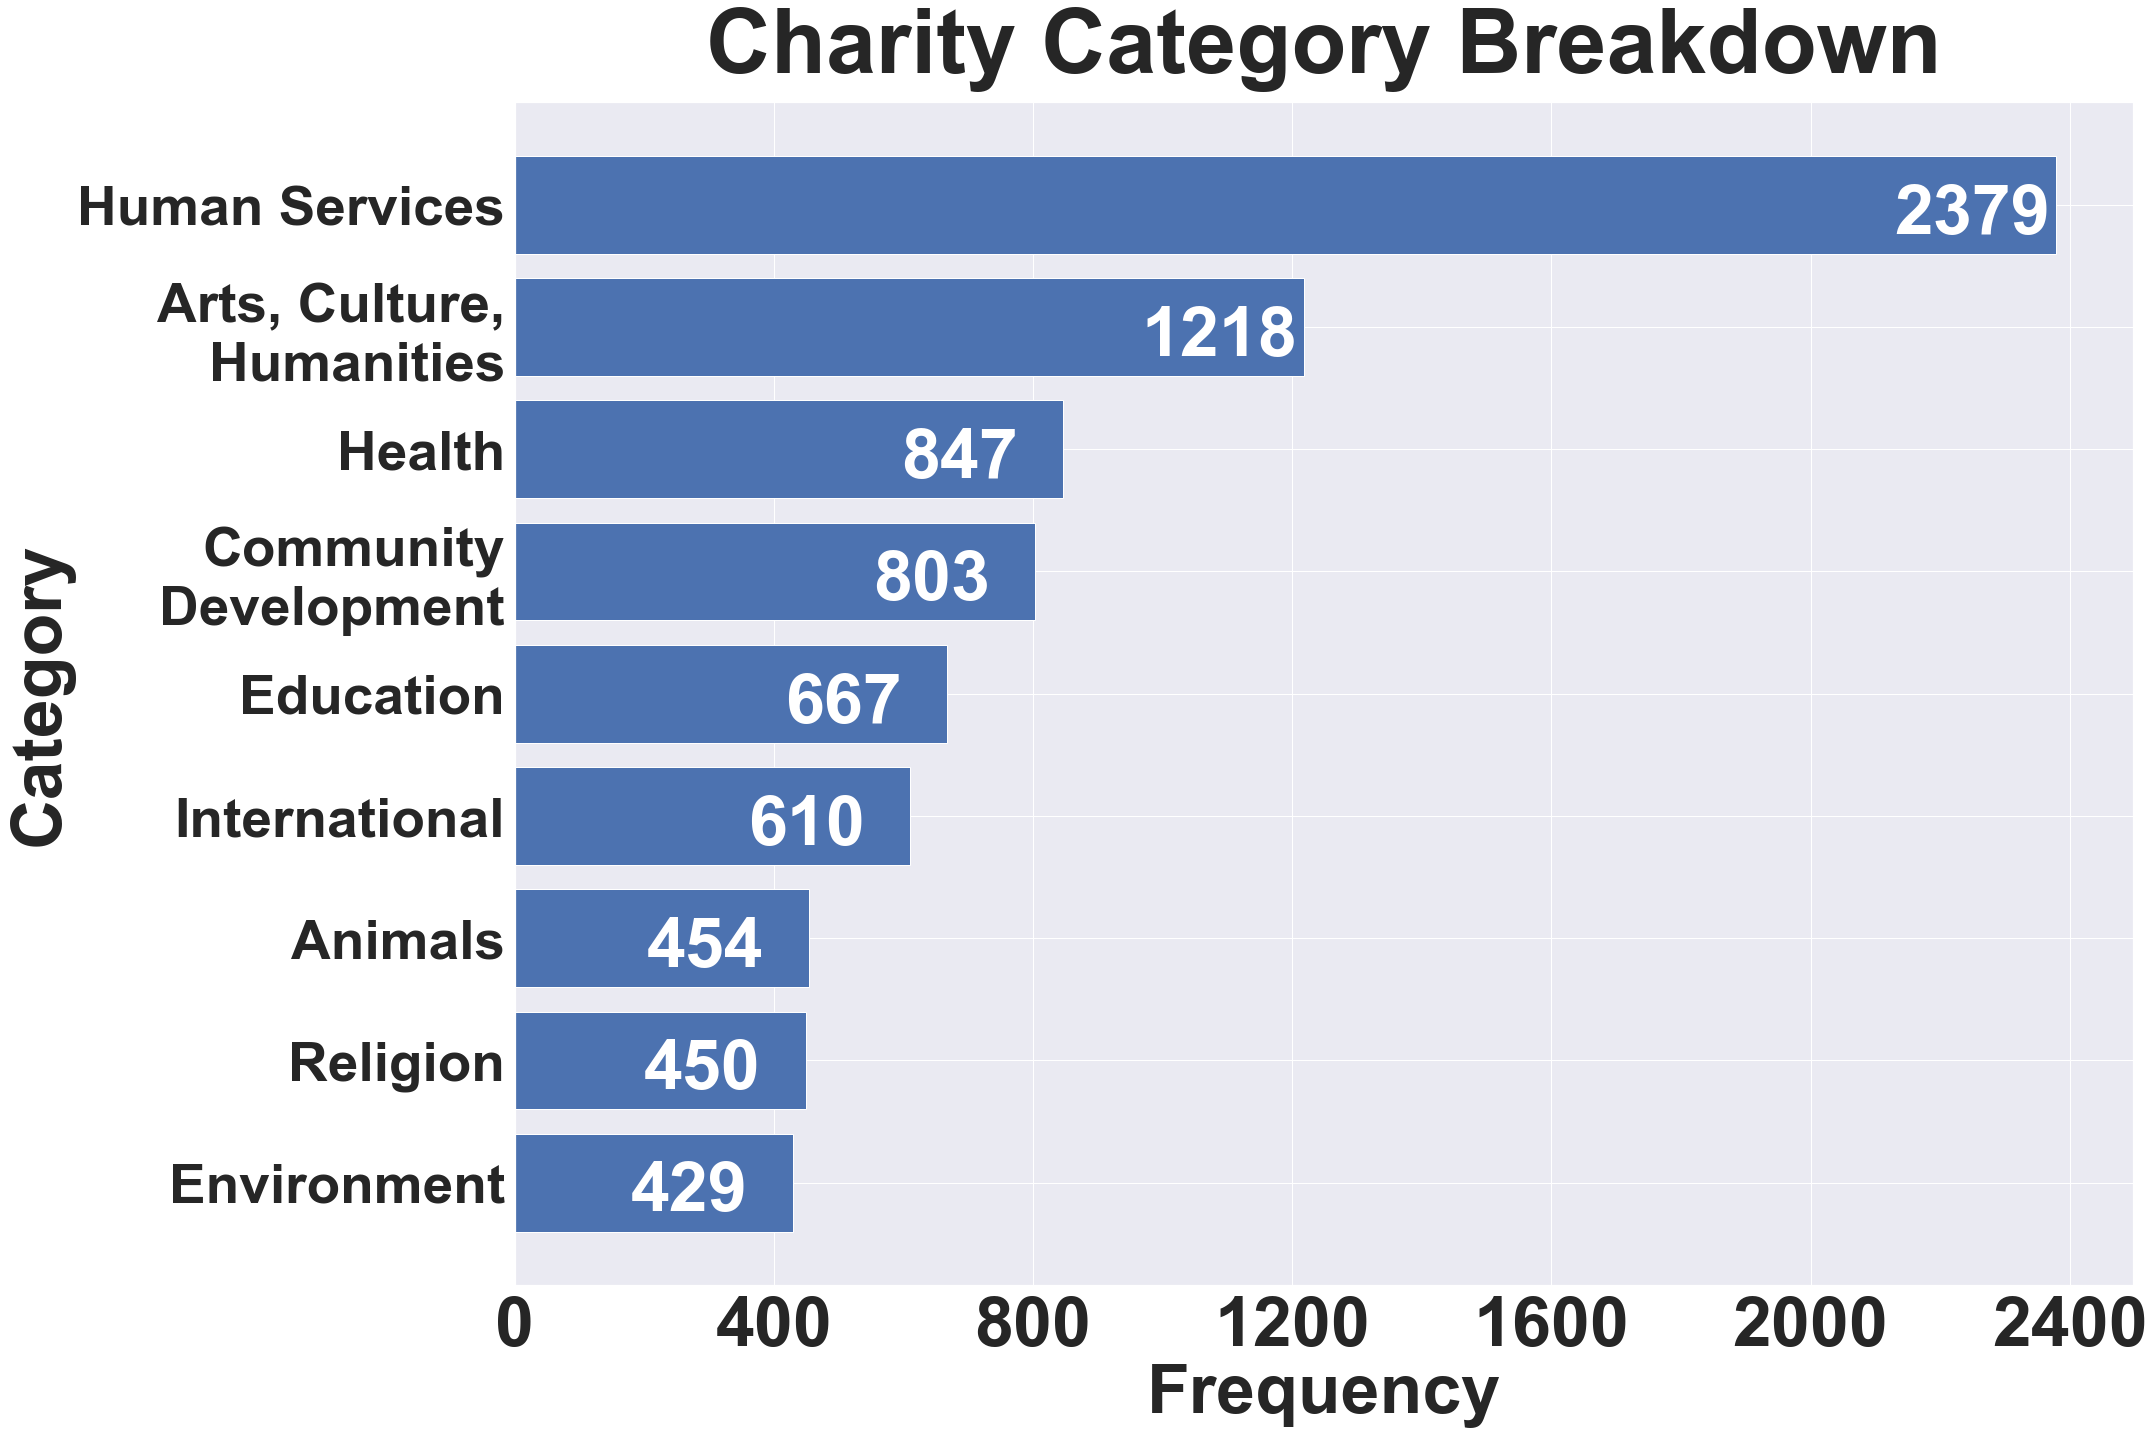

In [111]:
## Add Bar Chart

category_count = charity_navigator_df.groupby('category').size().sort_values(ascending=False)[:9]
categories = list(category_count.index.values)
freq = freq_array(category_count)

fig,ax = plt.subplots(figsize = (30,20))
ax.barh(categories,freq, color = "b");


# Title
ax.set_title("Charity Category Breakdown", weight = "bold", fontsize = 90, y=1.02);

# # X-axis
x_tick_nums = np.arange(0,np.max(category_count)+400,400)
ax.set_xticks(x_tick_nums)
ax.set_xticklabels(labels=x_tick_nums,weight='bold',fontsize=70)
ax.set_xlabel("Frequency", fontsize=70, weight = "bold");

# # Y-axis
categories_wrapped = wrap_axis_labels(categories, wrap_length=15)
ax.set_yticklabels(labels=categories_wrapped,weight='bold',fontsize=55)
ax.set_ylabel("Category", fontsize=70, weight = "bold");

set_labels_horizontal(category_count,ax,250,.23,c="white",fsize=70);

ax.invert_yaxis()  # labels read top-to-bottom

plt.tight_layout()

# plt.savefig('../IMG/CN_Categories.png')

In [66]:
round(category_count / category_count.sum() * 100,2)

category
Human Services               30.28
Arts, Culture, Humanities    15.50
Health                       10.78
Community Development        10.22
Education                     8.49
International                 7.76
Animals                       5.78
Religion                      5.73
Environment                   5.46
dtype: float64

## Score

In [83]:
charity_navigator_df['score']

0       91.94
1       85.59
2       76.80
3       91.95
4       90.26
        ...  
8403    79.36
8404    59.84
8405    88.07
8406    96.91
8407    92.29
Name: score, Length: 8408, dtype: float64

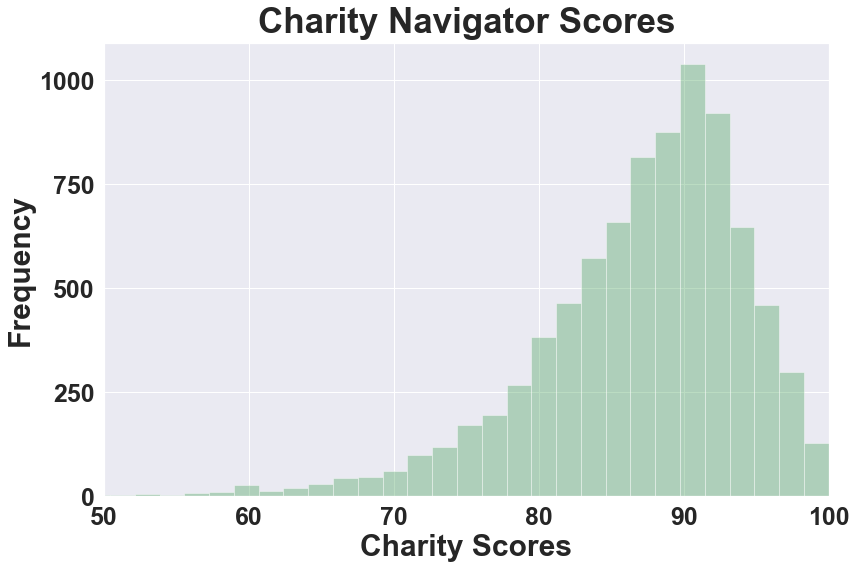

In [112]:
# Histogram of Charity Navigator Scores
fig, ax = plt.subplots(figsize=(12,8))

ax = sns.distplot(charity_navigator_df['score'],color = 'g',kde=False,hist=True,norm_hist=False)

# Title
ax.set_title(label="Charity Navigator Scores",weight='bold',fontsize=35, y=1.01)

# X-axis
x_tick_nums = np.arange(0,101,10)
ax.set_xticks(x_tick_nums)
ax.set_xticklabels(labels=x_tick_nums,weight='bold',fontsize=25)
ax.set_xlabel(xlabel="Charity Scores",weight='bold',fontsize=30)
ax.set_xlim([50, 100])

# Y-axis
y_tick_nums = np.arange(0,1101,250)
ax.set_yticks(y_tick_nums)
ax.set_yticklabels(labels=y_tick_nums,weight='bold',fontsize=25)
ax.set_ylabel(ylabel="Frequency",weight='bold',fontsize=30)

plt.tight_layout()

plt.savefig('../IMG/CharityNavScores.png')

In [19]:
# Add Histogram

## State

In [120]:
state_count = charity_navigator_df.groupby('state').size().sort_values(ascending=False)
state_count

state
CA    992
NY    963
TX    465
DC    447
FL    423
MA    344
VA    316
IL    309
PA    293
OH    250
CO    246
WA    213
MN    209
GA    207
MI    201
NC    195
TN    176
MD    167
NJ    166
MO    156
CT    130
IN    129
WI    129
AZ    124
OR    115
OK     80
SC     75
KY     73
AL     66
NE     61
LA     60
KS     57
UT     50
ME     48
IA     47
MT     44
MS     37
NM     36
NV     33
NH     33
AR     31
RI     31
VT     30
HI     28
SD     23
DE     23
ID     20
AK     17
WV     15
WY     13
ND      8
PR      3
VI      1
dtype: int64

In [154]:
# import folium
import plotly.graph_objects as go
## Add Choropleth Map

state_count = charity_navigator_df.groupby('state').size().sort_values(ascending=False)
ColorScale = 'blues'

fig = go.Figure(data=go.Choropleth(
    locations = state_count.index,
    z=state_count,
    zmax=1001,
    zmin=0,
    locationmode='USA-states',
    colorscale=ColorScale,
    autocolorscale=False,
    marker_line_color='black', # line markers between states
#     colorbar_title="Charity Counts"
))

fig.update_layout(
    title_text='Charity Counts by State',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()

## Character Lengths

In [22]:
char_corp_lengths = []
for i in charity_navigator_df['corpus']:
    char_corp_lengths.append(len(i))
char_corp_lengths = np.array(char_corp_lengths)
np.median(char_corp_lengths)

690.0

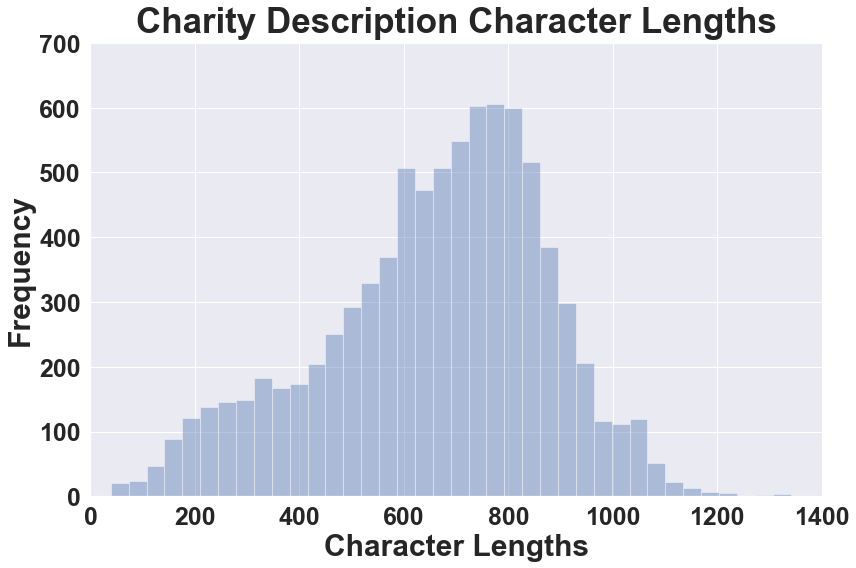

In [116]:
# Histogram of Charity Document Charity Lengths
fig, ax = plt.subplots(figsize=(12,8))

ax = sns.distplot(char_corp_lengths,color = 'b',kde=False,hist=True,norm_hist=False)

# Title
ax.set_title(label="Charity Description Character Lengths",weight='bold',fontsize=35, y=1.01)

# X-axis
x_tick_nums = np.arange(0,1601,200)
ax.set_xticks(x_tick_nums)
ax.set_xticklabels(labels=x_tick_nums,weight='bold',fontsize=25)
ax.set_xlabel(xlabel="Character Lengths",weight='bold',fontsize=30)
ax.set_xlim([0,1400])

# Y-axis
y_tick_nums = np.arange(0,701,100)
ax.set_yticks(y_tick_nums)
ax.set_yticklabels(labels=y_tick_nums,weight='bold',fontsize=25)
ax.set_ylabel(ylabel="Frequency",weight='bold',fontsize=30)

plt.tight_layout()

plt.savefig('../IMG/CharityDescCharacterLengths.png')

In [30]:
# There are 11 Categories Total
## A "Random Guess" Baseline is 1/11 = 9.09%

## Modeling

## Evaluating Model on Same Category Accuracy

In [31]:
# find_similar_charities_category_score(charity_navigator_df,charity_navigator_df,"description")

In [32]:
# find_similar_charities_category_score(charity_navigator_df,charity_navigator_df,"corpus")

In [33]:
# find_similar_charities_category_score(charity_navigator_df,charity_navigator_df,"motto")

In [34]:
# find_similar_charities_category_score(charity_navigator_df,charity_navigator_df,"category")

## Evaluating Model on Similarity Score Accuracy

In [35]:
# find_similar_charities_similar_score(charity_navigator_df,charity_navigator_df,"description")

In [36]:
# find_similar_charities_similar_score(charity_navigator_df,charity_navigator_df,"corpus")

In [37]:
# # Word Needs to Be in at least 4 documents:
# find_similar_charities_similar_score(charity_navigator_df,charity_navigator_df,"corpus")

In [38]:
# find_similar_charities_similar_score(charity_navigator_df,charity_navigator_df,"motto")

# LDA Topic Modeling

In [39]:
print("1. Processing Training Corpus")
    
char_desc_trimmed = np.array(charity_navigator_df['corpus'])

corpus = char_desc_trimmed
processed_corpus = process_corpus(corpus)

dictionary = corpora.Dictionary(processed_corpus)
features = (len(dictionary))

# Convert documents into Bag of Words (BoW) format
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]

# print("2. Creating Model from Training Corpus")
# index, dictionary, tfidf = create_index_from_corpus(processed_corpus)

1. Processing Training Corpus


In [40]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=8, id2word=dictionary, passes=2, workers=2)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.011*"habitat" + 0.009*"build" + 0.009*"building" + 0.008*"women" + 0.008*"county" + 0.007*"humanity" + 0.007*"affordable" + 0.006*"homes" + 0.005*"house" + 0.004*"service"
Topic: 1 
Words: 0.013*"strong" + 0.010*"homeless" + 0.007*"build" + 0.006*"healthy" + 0.006*"medical" + 0.006*"ymca" + 0.004*"home" + 0.004*"animal" + 0.004*"county" + 0.004*"child"
Topic: 2 
Words: 0.016*"build" + 0.012*"habitat" + 0.011*"healthy" + 0.011*"ymca" + 0.008*"together" + 0.007*"christian" + 0.007*"humanity" + 0.007*"homes" + 0.007*"strong" + 0.007*"home"
Topic: 3 
Words: 0.007*"habitat" + 0.005*"county" + 0.005*"american" + 0.005*"building" + 0.005*"serve" + 0.004*"greater" + 0.004*"humanity" + 0.004*"science" + 0.004*"rights" + 0.004*"girls"
Topic: 4 
Words: 0.006*"free" + 0.005*"museum" + 0.004*"helping" + 0.004*"around" + 0.004*"vision" + 0.004*"ywca" + 0.004*"women" + 0.004*"library" + 0.004*"empowering" + 0.004*"seniors"
Topic: 5 
Words: 0.008*"students" + 0.005*"artists" + 0.005

# Pickling Models

In [41]:
import pickle

In [42]:
charity_navigator_df.head()

,name,ein,category,description,motto,score,state,corpus
0,1000 Friends of Oregon,930642086,Environment,Working with Oregonians to enhance our quality...,Great communities. Working lands. Iconic Places.,91.94,OR,Environment Working with Oregonians to enhance...
1,WYPR,311770828,"Arts, Culture, Humanities",Serving the metropolitan Baltimore area and th...,88.1 FM -. Your NPR News Station,85.59,MD,"Arts, Culture, Humanities Serving the metropol..."
2,VSS Catholic Communications,911857425,Religion,VSS Catholic Communications is dedicated to an...,Spirit Catholic Radio Network,76.80,NE,Religion VSS Catholic Communications is dedica...
3,Utah Symphony & Opera,510145980,"Arts, Culture, Humanities",The mission of the Utah Symphony & Opera is to...,"Engaging, educating, and enriching lives",91.95,UT,"Arts, Culture, Humanities The mission of the U..."
4,Two Ten Footwear Foundation,222579809,Human Services,"Funded solely by the footwear industry, Two Te...",Shoepeople Helping Shoepeople,90.26,MA,Human Services Funded solely by the footwear i...


In [69]:
%%time
char_desc_trimmed = np.array(charity_navigator_df['corpus'])


CPU times: user 1.1 ms, sys: 2.04 ms, total: 3.13 ms
Wall time: 3.01 ms


In [70]:
%%time
corpus = char_desc_trimmed


CPU times: user 193 µs, sys: 3 µs, total: 196 µs
Wall time: 201 µs


In [71]:
%%time
processed_corpus = process_corpus(corpus)


CPU times: user 2.26 s, sys: 122 ms, total: 2.38 s
Wall time: 2.49 s


In [72]:
%%time
index, dictionary, tfidf = create_index_from_corpus(processed_corpus)

CPU times: user 2.58 s, sys: 41.7 ms, total: 2.62 s
Wall time: 2.64 s


In [43]:
# Train Model

print("1. Processing Training Corpus")
    
char_desc_trimmed = np.array(charity_navigator_df['corpus'])
corpus = char_desc_trimmed

processed_corpus = process_corpus(corpus)

print("2. Creating Model from Training Corpus")
index, dictionary, tfidf = create_index_from_corpus(processed_corpus)

1. Processing Training Corpus
2. Creating Model from Training Corpus


In [48]:
index

In [44]:
tfidf

In [45]:
# Save the model to disk
filename = 'finalized_model.sav'
pickle.dump(tfidf, open(filename, 'wb'))
 

In [74]:
# load the model from disk
loaded_model = pickle.load(open('finalized_model.sav', 'rb'))

In [73]:
# Save the index to disk
filename = 'finalized_index.sav'
pickle.dump(index, open(filename, 'wb'))

In [75]:
# load the index from disk
loaded_index = pickle.load(open('finalized_index.sav', 'rb'))

In [76]:
# Save the dictionary to disk
filename = 'finalized_dict.sav'
pickle.dump(dictionary, open(filename, 'wb'))

In [77]:
# load the dictionary from disk
loaded_dict = pickle.load(open('finalized_dict.sav', 'rb'))

In [47]:
loaded_model

In [62]:
document = ('Founded in 1974 by veterans, Swords to Plowshares is a community-based not-for-profit 501(c)(3) organization that provides needs assessment and case management, employment and training, housing, and legal assistance to approximately 3,000 veterans in the San Francisco Bay Area each year.')

In [78]:
%%time
query_bow = loaded_dict.doc2bow(document.split())

sims = loaded_index[loaded_model[query_bow]]

for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[1:4]:
    print(document_number, score)

6152 0.31632933
1701 0.3056355
4172 0.27560914
CPU times: user 9.61 ms, sys: 1.95 ms, total: 11.6 ms
Wall time: 9.86 ms


In [67]:
sims = index[tfidf[query_bow]]
        
top_3_sim = dict()
count = 3

for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[1:4]:
    print(document_number, score)

6152 0.31632933
1701 0.3056355
4172 0.27560914


In [68]:
sims = index[loaded_model[query_bow]]
        
top_3_sim = dict()
count = 3

for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[1:4]:
    print(document_number, score)

6152 0.31632933
1701 0.3056355
4172 0.27560914


In [ ]:
def create_index_from_corpus(processed_corpus):
    '''
    '''
    dictionary = corpora.Dictionary(processed_corpus)
    features = (len(dictionary))

    bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]

    # train the model
    tfidf = models.TfidfModel(bow_corpus)

    index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=features)

    return index, dictionary, tfidf

In [ ]:
# Get cosine similarity of vectors of documents
index = similarities.SparseMatrixSimilarity(loaded_model[bow_corpus], num_features=features)

In [91]:
def get_recs_from_pickled_model(document):
    '''
    '''
    # load the model from disk
    loaded_model = pickle.load(open('finalized_model.sav', 'rb'))
    # load the index from disk
    loaded_index = pickle.load(open('finalized_index.sav', 'rb'))
    # load the dictionary from disk
    loaded_dict = pickle.load(open('finalized_dict.sav', 'rb'))
    
    print(document)
    
    query_bow = loaded_dict.doc2bow(document.split())

    sims = loaded_index[loaded_model[query_bow]]

    top_3_sim = dict()
    
    for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[1:4]:
        top_3_sim[document_number] = score
        
    return top_3_sim

In [92]:
get_recs_from_pickled_model(document)

Founded in 1974 by veterans, Swords to Plowshares is a community-based not-for-profit 501(c)(3) organization that provides needs assessment and case management, employment and training, housing, and legal assistance to approximately 3,000 veterans in the San Francisco Bay Area each year.


{6152: 0.31632933, 1701: 0.3056355, 4172: 0.27560914}

In [95]:
get_recs_from_pickled_model("And I think to myself, what a wonderful world")

And I think to myself, what a wonderful world


{4617: 0.21756671, 7042: 0.20503633, 7255: 0.2020858}

In [96]:
("And I think to myself, what a wonderful world").split()

['And', 'I', 'think', 'to', 'myself,', 'what', 'a', 'wonderful', 'world']